# Jezebel Plutonium Sphere 
This example will consist of a simple benchmark composed of unreflected plutonium sphere (Jezebel). 
We begin obviously by importing the `tripoli5` and other things which will become handy later:

In [1]:
%load_ext wurlitzer

In [2]:
from tripoli5.core.euclide import Direction, Point
from tripoli5.core.physics import ParticleType
from tripoli5.core.literals import K, MeV
import tripoli5

### Material Definition
Now we need to define the mixture which will be the material of the sphere. For that purpose we create instance of a `MixtureBuilder` and call number of its methods in a chain to set all relevant properties:

In [3]:
catalog = tripoli5.delos.Catalog.fromFile(
    f"/opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v{tripoli5.delos.CATALOG_VERSION}.yaml"
)

# We need to open a bracket to break lines between each method in a chain!
Pu = (
    tripoli5.materials.MixtureBuilder(
        "concentrations"
    )  # We tell the builder to interpret input as density in 1/barn/cm
    .withName("Pu")  # Name of the mixture
    .withCatalog(catalog)
    .withTemperature(294 * K)
    .add("PU239", 0.037047)
    .add("PU240", 0.0017512)
    .add("PU241", 0.00011674)
    .add("GA69", 0.00083603)
    .add("GA71", 0.00053917)
    .build()
)

[2025-09-03 12:40:55.038] [info] Loading catalog from file: /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v2.2.0.yaml
[2025-09-03 12:40:55.076] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin


### Geometry Definition
Having defined the material we can now build the geometry of the problem. 

In [4]:
sphere = tripoli5.agora.Sphere(Point(0.0, 0.0, 0.0), 6.39157)

# We create a volume for the sphere and fill it with material
jez = tripoli5.agora.Volume(
    tripoli5.agora.Shape(-sphere), "Pu"  # Name of the Mixture as defined previously
)

However we require to define the entire space. So to deal with the boundary conditions correctly we need to define the 'outside' volume as well. We do it with a special syntax:

In [5]:
outside = tripoli5.agora.Volume.outside(
    tripoli5.agora.Shape(sphere)
    # Note the lack of material name
)

Having the both volumes we can assemble them into a full geometry description 

In [6]:
root_uni = tripoli5.agora.Universe([jez, outside])
geometry = tripoli5.agora.Geometry(
    root_uni
)  # We give it a root universe in the nesting tree

### Physics Configuration
We need to decide what kind of physical models and approximations we wish to use in the simulation. We perform it at the stage of building the `NeutronMedium`. It is fed with the material definition and uses it to load relevant nuclear data that can be used in the simulation 

In [7]:
media = (
    tripoli5.materials.NeutronMediumBuilder()
    .withCatalog(catalog)
    .withMixtures([Pu])
    .withURR("ace")
    .build()
)

[2025-09-03 12:40:55.173] [info] Building GA69 at temperatures: TemperatureRange(294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C])
[2025-09-03 12:40:55.176] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/GA69.294.bin
[2025-09-03 12:40:55.184] [info]   Building free gas collisions at temperature 294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C]
[2025-09-03 12:40:55.184] [info]   Building reaction MTs = 60, 72, 2, 61, 57, 28, 54, 55, 59, 62, 32, 91, 63, 64, 65, 53, 66, 67, 68, 69, 70, 58, 71, 56, 73, 102, 74, 103, 51, 22, 111, 52, 104, 16, 75, 105, 107, 106
[2025-09-03 12:40:55.184] [info] Building GA71 at temperatures: TemperatureRange(294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C])
[2025-09-03 12:40:55.186] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/GA71.294.bin
[2025-09-03 12:40:55.192] [info]   Building free gas collisions at temperature 294 [K], 2.5334957256

### Scores

Define MT reaction rates for total, capture and fission rates over an energy grid of 1000 groups defined with equivalent bins in lethargy using numpy.

In [8]:
import tripoli5.delos as delos
import numpy as np

mtrates = tripoli5.score.MTReactionRate(
    media,
    [delos.ReactionId(mt_number) for mt_number in [1, 102, 18]],
    1,  # number of volumes
    [e * MeV for e in np.logspace(-11, np.log(20), 1001)],
    "MTRates",
)
score_mgr = tripoli5.score.ScoreManager("jezebel")
score_mgr.addScore(mtrates)
score_mgr.initialize("")

### Configure and Run Criticality Calculation
We start by defining the source that will initialise the calculation

In [9]:
src = tripoli5.source.PointIsotropicSource(
    ParticleType("Neutron"),
    tripoli5.distributions.energy.MonoKinetic(2.0 * MeV),
    Point(0.0, 0.0, 0.0),
)

Common settings to different types of calculations (fixed source and criticality) are defined in a `SimulationParameters` object. We define it:

In [10]:
param = tripoli5.simulation.SimulationParameters(
    nb_cycles=110,
    nb_events=10000,  # Particles per cycle
    name="Jezebel",
    nb_threads=20,
    discard=10,
)

Finally we assemble the calculation using a simulation object. We also need to provide additional, specific calculation settings: 

In [11]:
simu = (
    tripoli5.simulation.SimulationBuilder(
        simulation_mode="criticality", parallelism_type="openmp"
    )
    .withSource(src)
    .withGeometry(geometry)
    .withMedia("Neutron", media)
    .withParameters(param)
    .withScores(score_mgr)
    .build()
)
simu.run()

[2025-09-03 12:40:55.353] [info] *** Beginning of simulation ***
[2025-09-03 12:40:55.369] [info] Cycle: 1 of 110
[2025-09-03 12:40:55.466] [info]   kstep = 1.39060
[2025-09-03 12:40:55.466] [info]   Mean number of collisions: 1.7762
[2025-09-03 12:40:55.468] [info] Cycle: 2 of 110
[2025-09-03 12:40:55.540] [info]   kstep = 1.14190
[2025-09-03 12:40:55.540] [info]   Mean number of collisions: 1.6969
[2025-09-03 12:40:55.542] [info] Cycle: 3 of 110
[2025-09-03 12:40:55.573] [info]   kstep = 1.05900
[2025-09-03 12:40:55.573] [info]   Mean number of collisions: 1.5753
[2025-09-03 12:40:55.575] [info] Cycle: 4 of 110
[2025-09-03 12:40:55.603] [info]   kstep = 1.02550
[2025-09-03 12:40:55.603] [info]   Mean number of collisions: 1.5169
[2025-09-03 12:40:55.605] [info] Cycle: 5 of 110
[2025-09-03 12:40:55.633] [info]   kstep = 1.01480
[2025-09-03 12:40:55.633] [info]   Mean number of collisions: 1.4855
[2025-09-03 12:40:55.634] [info] Cycle: 6 of 110
[2025-09-03 12:40:55.659] [info]   kstep 

And as we expect we can read the k_eff to find that it is 1.0 within the error as expected 😉

In [12]:
import numpy as np

k_tally = simu.getKStep()
mean = k_tally.mean
std = np.sqrt(k_tally.var)
print(f"k-eff: {mean}±{std}")

k-eff: [1.002383]±[0.00156918]


You can write results into a csv file

In [13]:
mtrates.writeToFile("mt-rates-jezebel.log")
with open("mt-rates-jezebel.log") as f:
    for _ in range(5):
        print(f.readline(), end="")

volume_rank   group_id      E             MT            name          mean                    mean_std                
0             0             1.00000e-11   1             z,total       0.0000000000000000e+00  0.0000000000000000e+00  
0             0             1.00000e-11   102           z,g           0.0000000000000000e+00  0.0000000000000000e+00  
0             0             1.00000e-11   18            z,fission     0.0000000000000000e+00  0.0000000000000000e+00  
0             1             1.03275e-11   1             z,total       0.0000000000000000e+00  0.0000000000000000e+00  


You can then read them as a pandas.DataFrame

In [14]:
from matplotlib import pyplot as plt
import pandas as pd

df = pd.read_csv("mt-rates-jezebel.log", sep=r"\s+")
df.head()

volume_rank  group_id             E   MT       name  mean  mean_std
0            0         0  1.000000e-11    1    z,total   0.0       0.0
1            0         0  1.000000e-11  102        z,g   0.0       0.0
2            0         0  1.000000e-11   18  z,fission   0.0       0.0
3            0         1  1.032750e-11    1    z,total   0.0       0.0
4            0         1  1.032750e-11  102        z,g   0.0       0.0

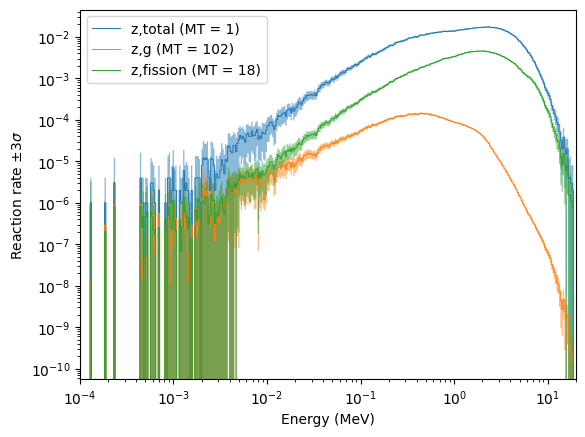

In [15]:
for mt in df.MT.unique():
    df_partial = df[df.MT == mt]
    plt.plot(
        df_partial["E"].values,
        df_partial["mean"].values,
        linestyle="-",
        linewidth=0.7,
        drawstyle="steps-post",
        label=f"{df_partial['name'].unique()[0]} (MT = {mt})",
    )
    plt.fill_between(
        df_partial["E"].values,
        df_partial["mean"].values - 3 * df_partial["mean_std"].values,
        df_partial["mean"].values + 3 * df_partial["mean_std"].values,
        alpha=0.5,
        step="post",
    )
plt.xlabel("Energy (MeV)")
plt.ylabel(r"Reaction rate $\pm 3 \sigma$")
plt.xlim(1e-4, 20)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

Or you can directly access means and variances as numpy arrays

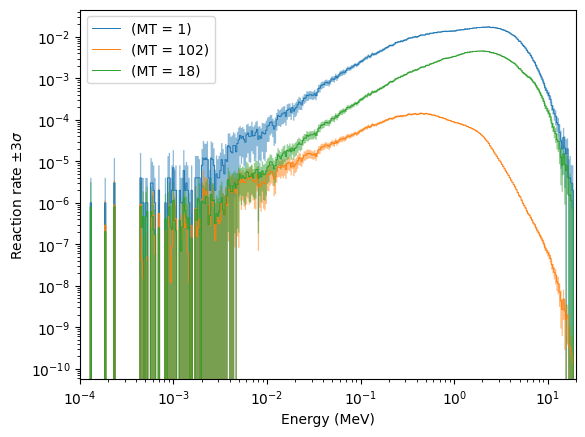

In [16]:
means = mtrates.mean
vars = mtrates.var
mean_std = np.sqrt(vars)
energy_bounds_in_mev = mtrates.energy_bounds
# for now, retrieving the means and variances as numpy arrays does not allow to retrieve corresponding columns names
# the shape is (nb_volumes, nb_energy_groups, nb_mts)
for mt_index, mt in enumerate([1, 102, 18]):
    plt.plot(
        energy_bounds_in_mev[:-1],
        means[0, :, mt_index],
        linestyle="-",
        linewidth=0.7,
        drawstyle="steps-post",
        label=f"(MT = {mt})",
    )
    plt.fill_between(
        energy_bounds_in_mev[:-1],
        means[0, :, mt_index] - 3 * mean_std[0, :, mt_index],
        means[0, :, mt_index] + 3 * mean_std[0, :, mt_index],
        alpha=0.5,
        step="post",
    )


plt.xlabel("Energy (MeV)")
plt.ylabel(r"Reaction rate $\pm 3 \sigma$")
plt.xlim(1e-4, 20)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()